In [1]:

### Preparation

# Load Modules
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Set Plotting Styles
plt.style.use('ggplot') 
matplotlib.rcParams['figure.figsize'] = (18, 18) #显示图像的最大范围

# Load Data
Unit_df = pd.read_csv('data/data.csv'
                      , usecols = [0, 4, 5, 6, 7, 8, 9, 10, 11, 12]
                      , header = 0
                      , names = ["Datetime"
                                 , "total_value"
                                 , "VRF1_value"
                                 , "VRF2_value"
                                 , "lighting1_value"
                                 , "lighting2_value"
                                 , "temperature"
                                 , "enthalpy"
                                 , "relative_humidity"
                                 , "radiation"]
                      , index_col=[0]
                      , parse_dates=[0]
                      , encoding= 'ISO-8859-1')

# Create Features
def get_time_state(time):
    if time in range(8, 18):
        return 1
    else:
        return 0
    
def get_work_state(DayOfWeek):
    if DayOfWeek in range(1, 6):
        return 1
    else:
        return 0

def create_features(df):
    df['Date'] = df.index
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['DayOfMonth'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['DayOfYearFloat'] = df['DayOfYear'] + df['Hour'] / 24
    df['Time_state'] = df.apply(lambda x: get_time_state(x['Hour']), axis=1)
    df['Working_state'] = df.apply(lambda x: get_work_state(x['DayOfWeek']), axis=1)
    df.drop('Date', axis=1, inplace=True)
    return df
Unit_df = create_features(Unit_df)

### Feature Engineering

# maximum Pearson correlation coefficient
def Pearson_correlation():
    for i in ["VRF1_value", "VRF2_value", "lighting1_value", "lighting2_value"]:
        corr = Unit_df.loc[:,["lighting2_value",i]].corr(method='pearson')
        print(i)
        print(corr)

#Pearson_correlation()
    
def create_training_sample(datatype):
    # Construction of historical training data set in the normalbranch, this step takes the historical energy consumption data as a
    # sample in a day and the 15-dimensional training sample TP 
    data = pd.DataFrame(columns=[list(map(str, list(range(7, 22))))])
    lighting1_columns_index = Unit_df.columns.get_loc(datatype)
    for i in range(Unit_df.shape[0]//15):
        i*=15
        lis = []
        #lis.append(Unit_df.index[i].strftime("%Y-%m-%d"))
        for j in range(15):
            lis.append(Unit_df.iloc[i+j,lighting1_columns_index])
        data.loc[i//15] = lis
    data.set_index(Unit_df.index[0::15], inplace=True)
    return data
        
lighting1_value = create_training_sample('lighting1_value')
lighting2_value = create_training_sample('lighting2_value')

def Distance_calculation(dataname, a, b):
    # calculation certain data's Euclidean Distance between date a and date b 
    sum = 0
    for i in (dataname.iloc[a][0:] - dataname.iloc[b][0:]):
        sum += pow(i, 2)
    return pow(sum, 0.5)

def bubbleSort(arr):
    n = len(arr)
 
    # 遍历所有数组元素
    for i in range(n):
 
        # Last i elements are already in place
        for j in range(0, n-i-1):
 
            if arr[j][1] < arr[j+1][1] :
                arr[j], arr[j+1] = arr[j+1], arr[j]
            
def Find_historical_similar_dataset(dataname, a, K):
    #K is not finished
    lis = list(range(dataname.shape[0]))
    lis.remove(a)
    dateset1 = []
    for n in range(K):
        dateset1.append([0, 1e10])
    for i in lis:
        value = Distance_calculation(dataname, a, i) 
        for j in dateset1:
            if value < j[1]:
                j[0] = dataname.iloc[i].name
                j[1] = value
                bubbleSort(dateset1)
                break
    dateset2 = []
    for i in dateset1:
        dateset2.append(i[0])
    return dateset2
 
def get_SECF(datanameA, datanameB, K):
    #The energy consumption at the same time as setA can be found from the historical data of the abnormal branch, and is denoted as setB.
    #if K != 3 a,b,c.... should be insteaded by other variable whose numbers equals K
    SECF = []
    for i in range(datanameA.shape[0]):
        dateset = Find_historical_similar_dataset(datanameA, i, K)
        F = []
        for j in dateset:
            F.append(list(datanameB.loc[j]))
        SECF += [(a + b + c) / 3 for a, b, c in zip(F[0], F[1], F[2])]
    return SECF

lighting2_value_SECF = get_SECF(lighting1_value, lighting2_value, 3)
Unit_df.insert(Unit_df.shape[1], 'lighting2_value_SECF', lighting2_value_SECF)
Unit_df.to_csv('data/df.csv',sep=',',index=True,header=True)

In [143]:
Unit_df

,total_value,VRF1_value,VRF2_value,lighting1_value,lighting2_value,temperature,enthalpy,relative_humidity,radiation,Hour,...,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat,Time_state,Working_state,lighting2_value_SECF
Datetime,,,,,,,,,,,,,,,,,,,,,
2016-07-08 07:00:00,18.53,3.60,2.03,8.192,4.708,22.5,62.78,92,0.0,7,...,3,7,2016,190,8,27,190.291667,0,1,6.050000
2016-07-08 08:00:00,44.12,10.88,7.24,16.912,9.088,22.8,62.94,90,0.0,8,...,3,7,2016,190,8,27,190.333333,1,1,9.930000
2016-07-08 09:00:00,63.90,26.32,10.52,15.544,11.516,23.0,63.18,89,0.0,9,...,3,7,2016,190,8,27,190.375000,1,1,9.233333
2016-07-08 10:00:00,61.93,21.20,13.30,16.032,11.398,24.7,65.79,82,204.0,10,...,3,7,2016,190,8,27,190.416667,1,1,9.550667
2016-07-08 11:00:00,58.95,20.24,13.22,14.744,10.746,26.0,66.63,75,720.0,11,...,3,7,2016,190,8,27,190.458333,1,1,8.370667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-06 17:00:00,64.32,22.30,13.96,17.920,10.140,22.3,60.31,88,86.0,17,...,3,9,2019,249,6,36,249.708333,1,1,8.678667
2019-09-06 18:00:00,36.52,9.76,8.71,12.688,5.362,22.0,54.99,78,2.0,18,...,3,9,2019,249,6,36,249.750000,0,1,5.713333
2019-09-06 19:00:00,24.79,5.60,5.56,9.392,4.238,22.5,61.44,89,0.0,19,...,3,9,2019,249,6,36,249.791667,0,1,4.792000


In [53]:
min(list(Unit_df.loc[:,'lighting2_value_SECF']))

1.6773333333333333

In [4]:
# generate regression datasets
class Bunch(dict):
    def __init__(self, *args, **kwargs):
        super(Bunch, self).__init__(*args, **kwargs)
        self.__dict__ = self

def load_data(data_csv):
    # data_csv
    data = Bunch()
    data.data = _get_data(data_csv)
    data.target = _get_target(data_csv)
    data.DESCR = _get_descr(data_csv)
    data.feature_names = _get_feature_names()
    data.target_names = _get_target_names()

    return data

def _get_data(data):
    """
    获取特征值
    :return:
    """
    data_r = data.loc[:, ['temperature'
                          , 'enthalpy'
                          , 'relative_humidity'
                          , 'radiation'
                          , 'lighting2_value_SECF'
                          , 'Time_state'
                          , 'Working_state']]
    data_np = np.array(data_r)
    return data_np


def _get_target(data):
    """
    获取目标值
    :return:
    """
    data_b = data.loc[:, 'lighting2_value']
    data_np = np.array(data_b)
    return data_np


def _get_descr(data):
    """
    获取数据集描述
    :return:
    """
    text = "本数据集选取了2016-2019年夏季每日9:00:00-21:00:00的数据，样本数量：{}；" \
           "特征数量：{}；目标值数量：{}；无缺失数据" \
           "".format(data.shape[0], 7, 1)
    return text


def _get_feature_names():
    """
    获取特征名字
    :return:
    """
    fnames = ["temperature"
              , "enthalpy"
              , "relative_humidity"
              , "radiation"
              , "lighting2_value_SECF"
              , 'Time_state'
              , 'Working_state'
             ]
    return fnames


def _get_target_names():
    """
    获取目标值名称
    :return:
    """
    tnames = ["lighting2_value"]
    return tnames

# prediction
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
#from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
from time import time
import datetime


from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2, f_regression


data = load_data(Unit_df)
X = data.data
y = data.target

Xtrain,Xtest,Ytrain,Ytest = TTS(X,y,test_size=0.2,random_state=10, shuffle=False)

In [155]:
Xtest.shape

(861, 7)

VRF1_value
                 lighting2_value  VRF1_value
lighting2_value         1.000000    0.610226
VRF1_value              0.610226    1.000000
VRF2_value
                 lighting2_value  VRF2_value
lighting2_value         1.000000    0.586922
VRF2_value              0.586922    1.000000
lighting1_value
                 lighting2_value  lighting1_value
lighting2_value         1.000000         0.880464
lighting1_value         0.880464         1.000000
lighting2_value
                 lighting2_value  lighting2_value
lighting2_value              1.0              1.0
lighting2_value              1.0              1.0
lighting2_value_SECF
                      lighting2_value  lighting2_value_SECF
lighting2_value              1.000000              0.889096
lighting2_value_SECF         0.889096              1.000000


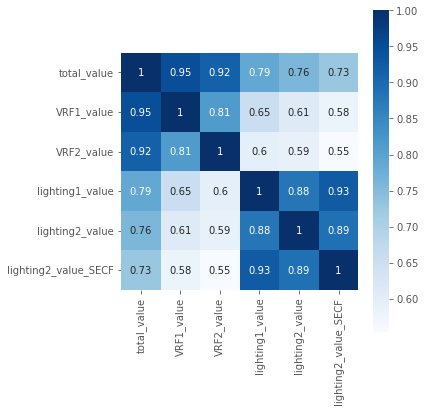

In [49]:
for i in ["VRF1_value", "VRF2_value", "lighting1_value", "lighting2_value", 'lighting2_value_SECF']:
        corr = Unit_df.loc[:,["lighting2_value",i]].corr(method='pearson')
        print(i)
        print(corr)
        
def showcov(df):
    dfData = df.corr()
    plt.subplots(figsize=(6, 6)) # 设置画面大小
    sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
    #matplotlib.rcParams.update({'font.size': 10})
    plt.tight_layout() # Make the text inside the picture
    plt.savefig('images/BluesStateRelation.png')
    plt.show()
 
showcov(Unit_df.loc[:,["total_value", "VRF1_value", "VRF2_value", "lighting1_value", "lighting2_value", 'lighting2_value_SECF']])

In [75]:
reg = XGBR(n_estimators= 100
           , max_depth = 4
           , learning_rate = 0.12
           , gamma = 0.1
           , min_child_weight = 5
           , subsample = 0.8
           , colsample_bytree = 0.8
           , reg_alpha = 0.5
           , reg_lambda = 1
           ).fit(Xtrain,Ytrain)
reg.get_booster().feature_names = data.feature_names
reg.predict(Xtest) #传统接口predict
result = reg.score(Xtest,Ytest) #Return the coefficient of determination of the prediction
result

0.4018107916678465

In [7]:
MSE(Ytest, reg.predict(Xtest))

2.1081184488622386

In [10]:
y.mean()

5.080236933797213

In [16]:
# 模型评估指标
reg = XGBR(n_estimators=100)
CVS(reg,Xtrain,Ytrain,cv=5).mean() #MSE

0.71220898753523

In [14]:
CVS(reg,Xtrain,Ytrain,cv=5, scoring="neg_mean_squared_error").mean()

-7.064281330209734

In [15]:
rfr = RFR(n_estimators=100)
CVS(rfr,Xtrain,Ytrain,cv=5).mean()

0.7457943549266888

In [17]:
lr = LinearR()
CVS(lr,Xtrain,Ytrain,cv=5).mean()


0.7820067453556442

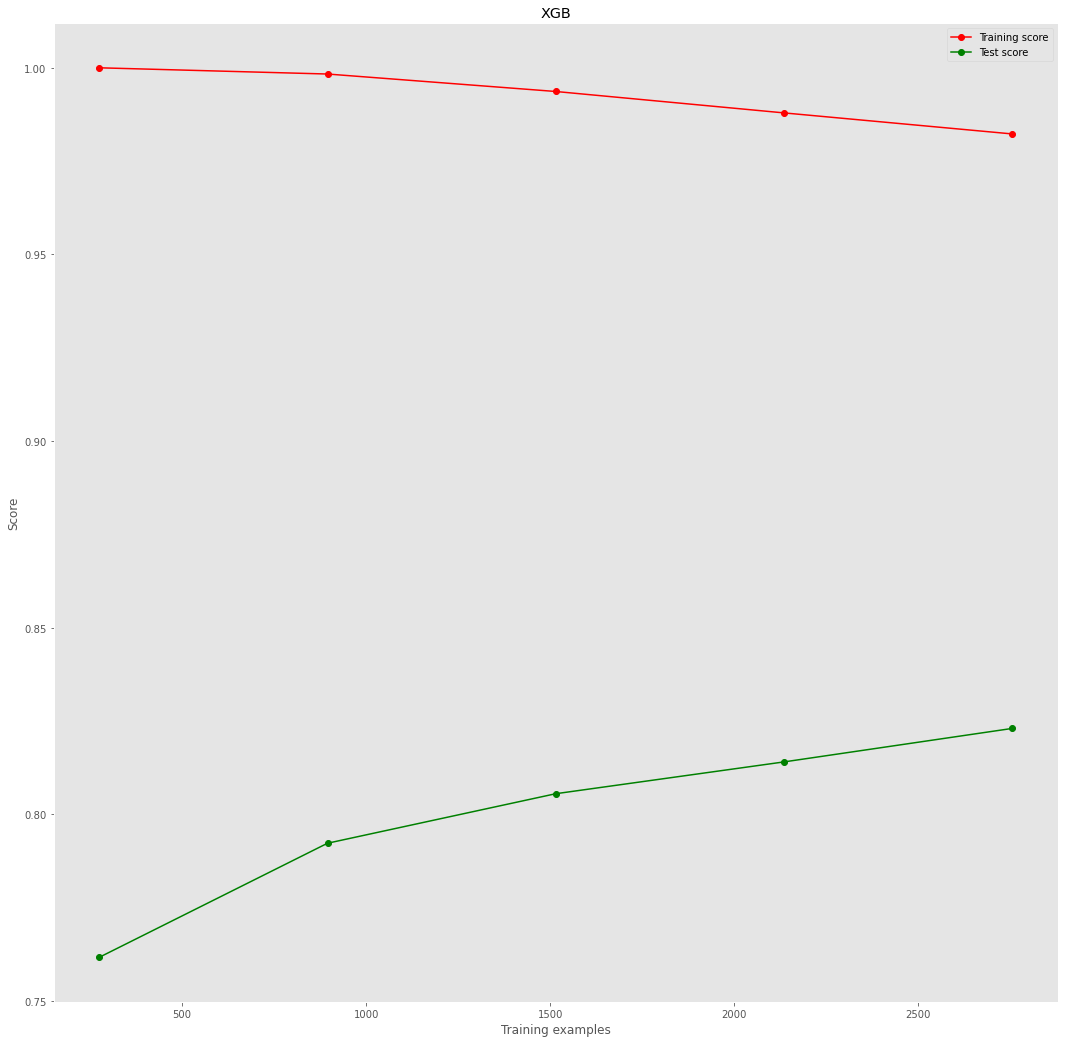

In [164]:
reg = XGBR(n_estimators=200
           , max_depth = 7
           , learning_rate = 0.06
           , gamma = 0.1
           , min_child_weight = 3
           , subsample = 0.8
           , colsample_bytree = 0.8
           , reg_alpha = 0.05
           , reg_lambda = 0.05
           ).fit(Xtrain,Ytrain)
reg.predict(Xtest) #传统接口predict
reg.score(Xtest,Ytest) #你能想出这里应该返回什么模型评估指标么？
MSE(Ytest,reg.predict(Xtest))
reg.feature_importances_ #树模型的优势之一：能够查看模型的重要性分数，可以使用嵌入法（SelectFromModel）进行特征选择

# reg = XGBR(n_estimators=100)
# CVS(reg,Xtrain,Ytrain,cv=5).mean()

def plot_learning_curve(estimator,title, X, y,
                        ax=None, #选择子图
                        ylim=None, #设置纵坐标的取值范围
                        cv=None, #交叉验证
                        n_jobs=None #设定索要使用的线程
                        ):

    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                            ,shuffle=True
                                                            ,cv=cv
                                                            # ,random_state=420
                                                            ,n_jobs=n_jobs)
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid() #绘制网格，不是必须
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
            , color="r",label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
            , color="g",label="Test score")
    ax.legend(loc="best")
    return ax

cv = KFold(n_splits=5, shuffle = True
           , random_state=42
          )
plot_learning_curve(XGBR(n_estimators=100,random_state=420)
                    ,"XGB",Xtrain,Ytrain,ax=None,cv=cv)
plt.show()

60 0.8274811373078734


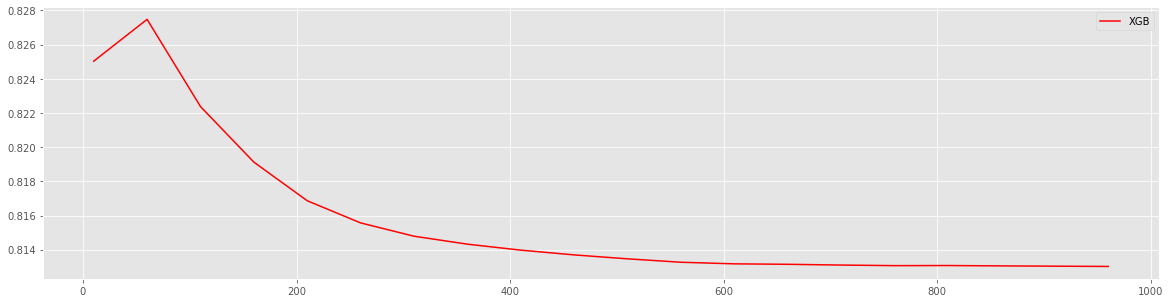

In [10]:
cv = KFold(n_splits=5, shuffle = True
           , random_state=42
          )
axisx = range(10,1010,50)
rs = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    rs.append(CVS(reg,Xtrain,Ytrain,cv=cv).mean())
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()

20 0.8308886828914046 9.006691598493866e-05
45 0.8285476377663414 5.362788293255753e-05
20 0.8308886828914046 9.006691598493866e-05 0.028688704490188847


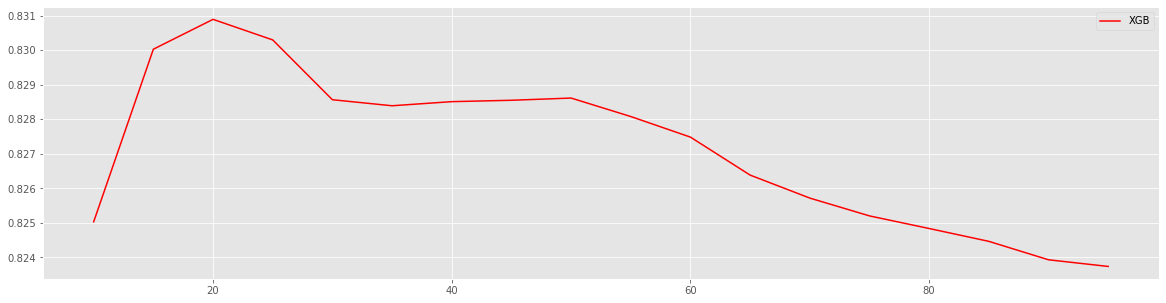

In [15]:
#======【TIME WARNING: 20s】=======#
cv = KFold(n_splits=5, shuffle = True
           , random_state=42
          )
axisx = range(10,100,5)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    cvresult = CVS(reg,Xtrain,Ytrain,cv=cv)
    #记录1-偏差
    rs.append(cvresult.mean())
    #记录方差
    var.append(cvresult.var())
    #计算泛化误差的可控部分
    ge.append((1 - cvresult.mean())**2+cvresult.var())
#打印R2最高所对应的参数取值，并打印这个参数下的方差
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
#打印方差最低时对应的参数取值，并打印这个参数下的R2
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
#打印泛化误差可控部分的参数取值，并打印这个参数下的R2，方差以及泛化误差的可控部分
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()

In [70]:
reg = XGBR(n_estimators=200
           , max_depth = 7
           , learning_rate = 0.06
          )

reg = reg.fit(Xtrain,Ytrain)

reg.get_booster().feature_names = data.feature_names

result = reg.score(Xtest,Ytest)

result

0.3690730422190224

100 0.8074716830805191 0.00020148532596237515
100 0.8074716830805191 0.00020148532596237515
100 0.8074716830805191 0.00020148532596237515 0.03726863814181046


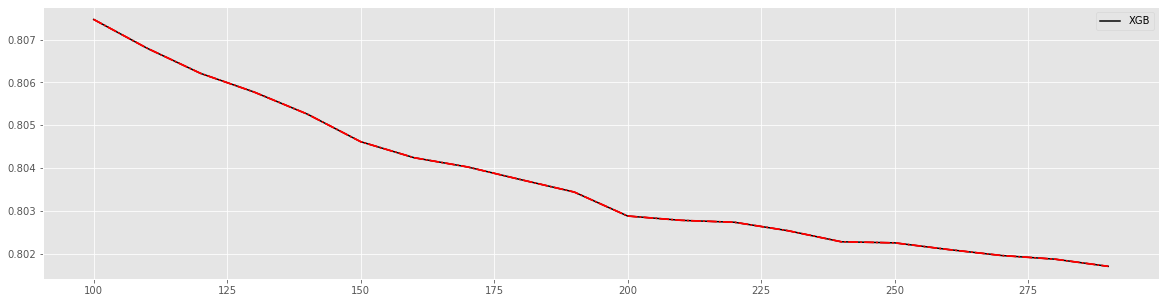

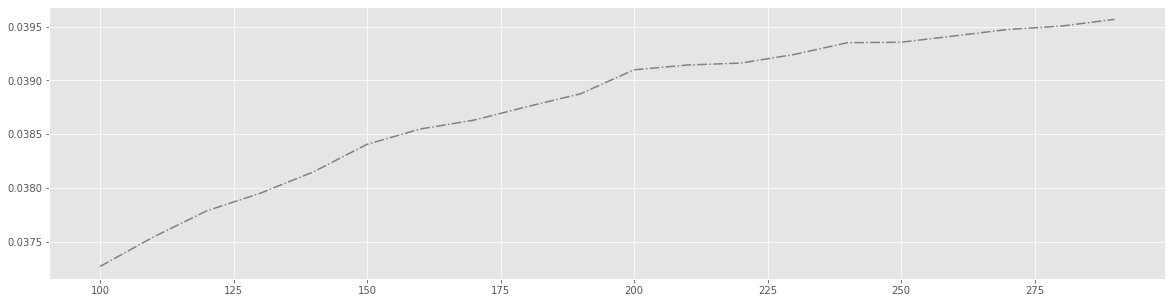

In [43]:
axisx = range(100,300,10)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    cvresult = CVS(reg,Xtrain,Ytrain,cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs = np.array(rs)
var = np.array(var)*0.01
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="black",label="XGB")
#添加方差线
plt.plot(axisx,rs+var,c="red",linestyle='-.')
plt.plot(axisx,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()
#看看泛化误差的可控部分如何？
plt.figure(figsize=(20,5))
plt.plot(axisx,ge,c="gray",linestyle='-.')
plt.show()

In [49]:
#验证模型效果是否提高了？
time0 = time()
print(XGBR(n_estimators=200,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest))
print(time()-time0)
time0 = time()
print(XGBR(n_estimators=12,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest))
print(time()-time0)
time0 = time()
print(XGBR(n_estimators=5,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest))
print(time()-time0)


0.7924787443595587
0.37607836723327637
0.8042855124819024
0.027005910873413086
0.701556789144405
0.015003442764282227


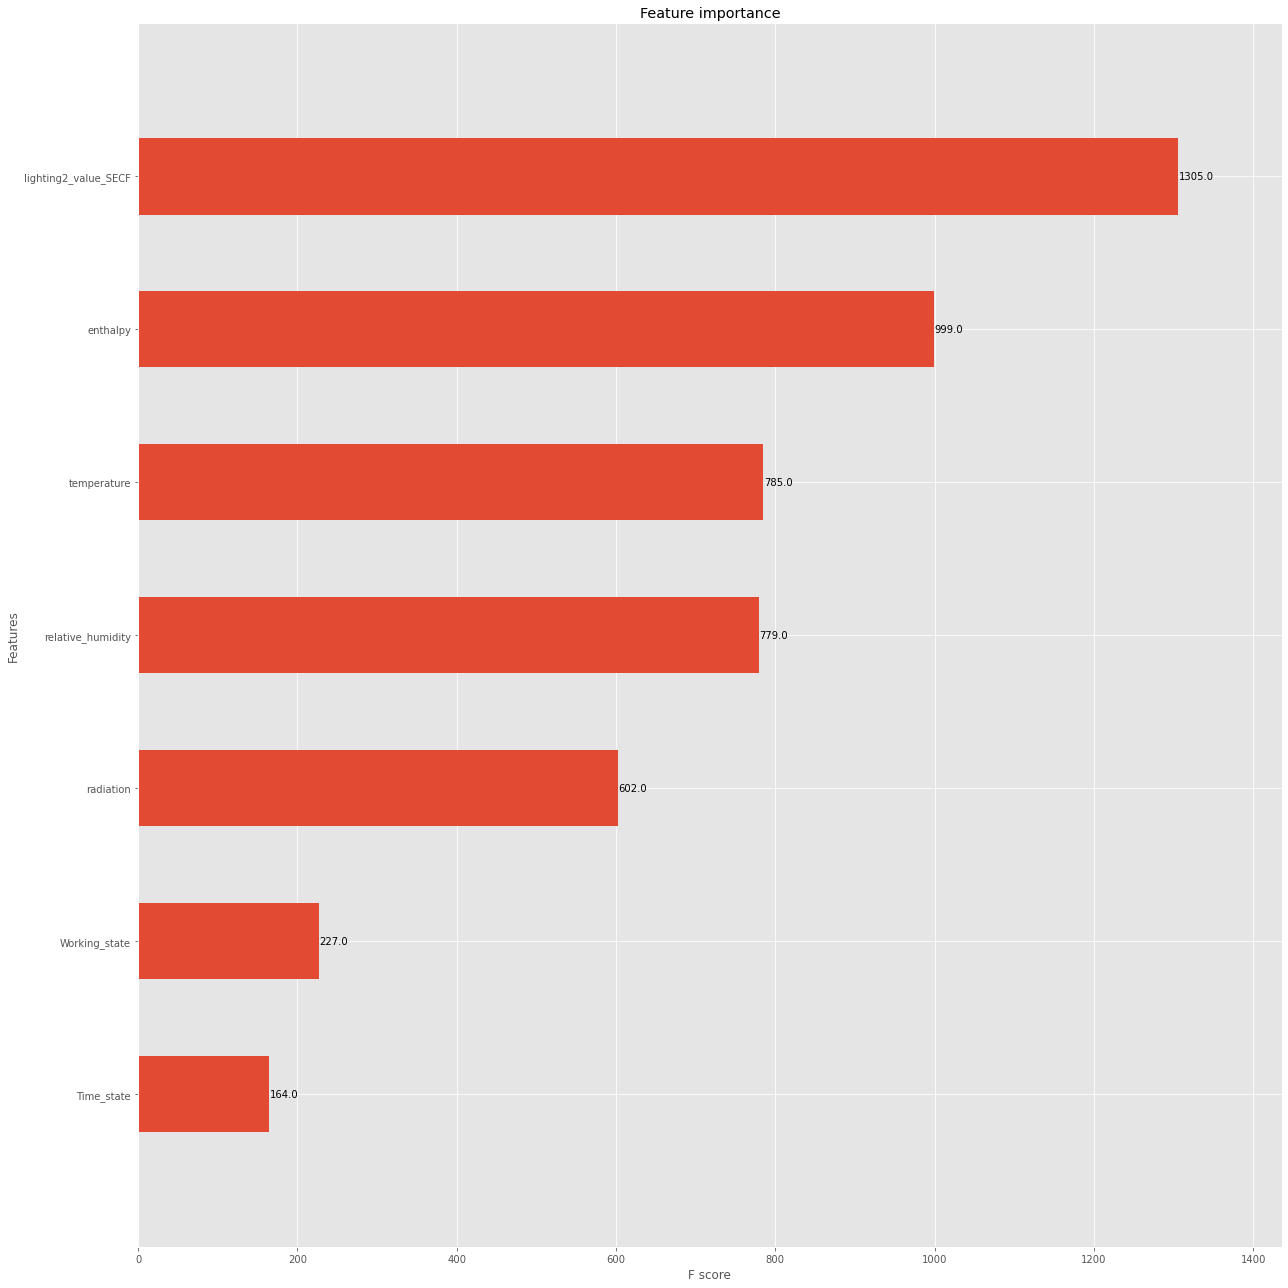

In [177]:
from xgboost import plot_importance
def Feature_importance():
    xgbr_y_predict=reg.predict(Xtest)

    plot_importance(reg, height = 0.5)

    # fontsize
    #plt.xticks(fontsize=30)
    #plt.yticks(fontsize=30)
    #matplotlib.rcParams.update({'font.size': 30})

    plt.tight_layout() # Make the text inside the picture

    plt.savefig('images/Feature_importance_plot.png')

    plt.show()
Feature_importance()

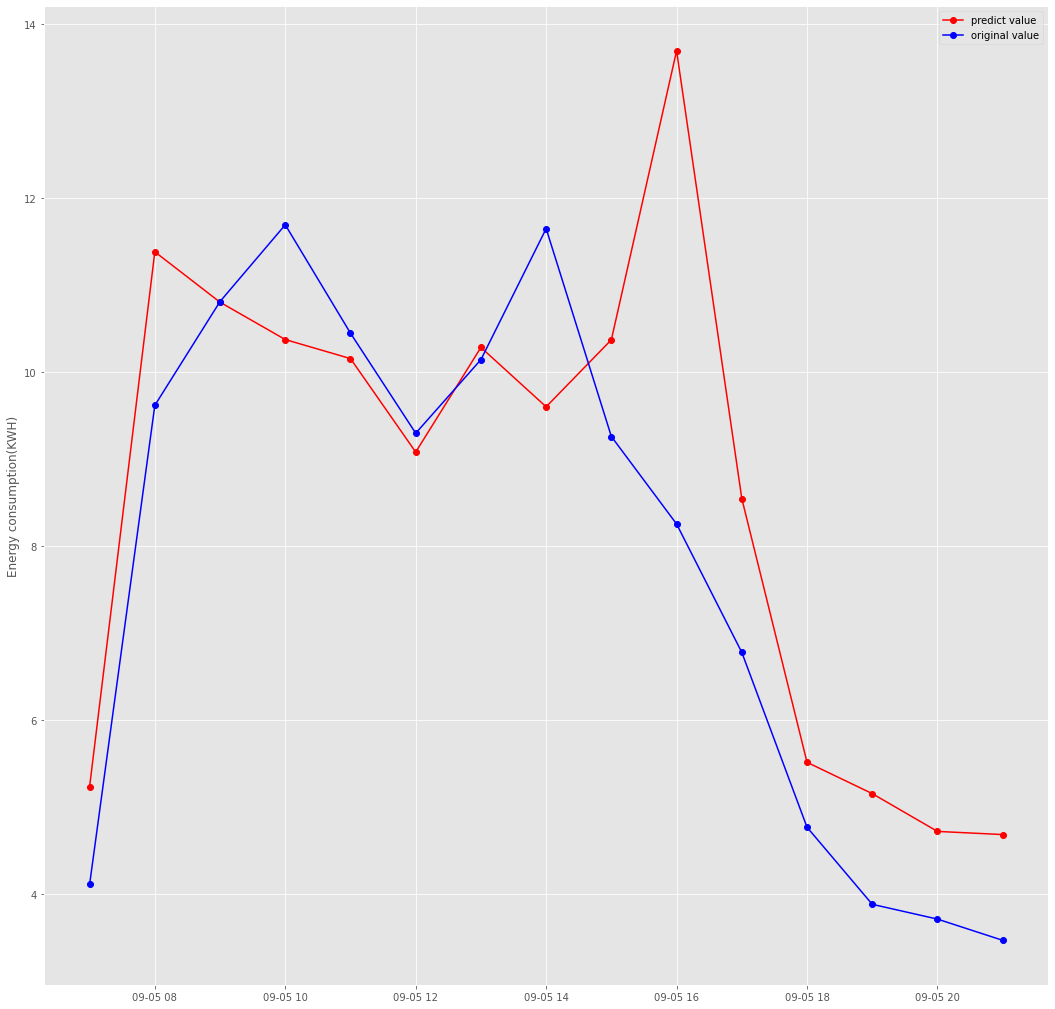

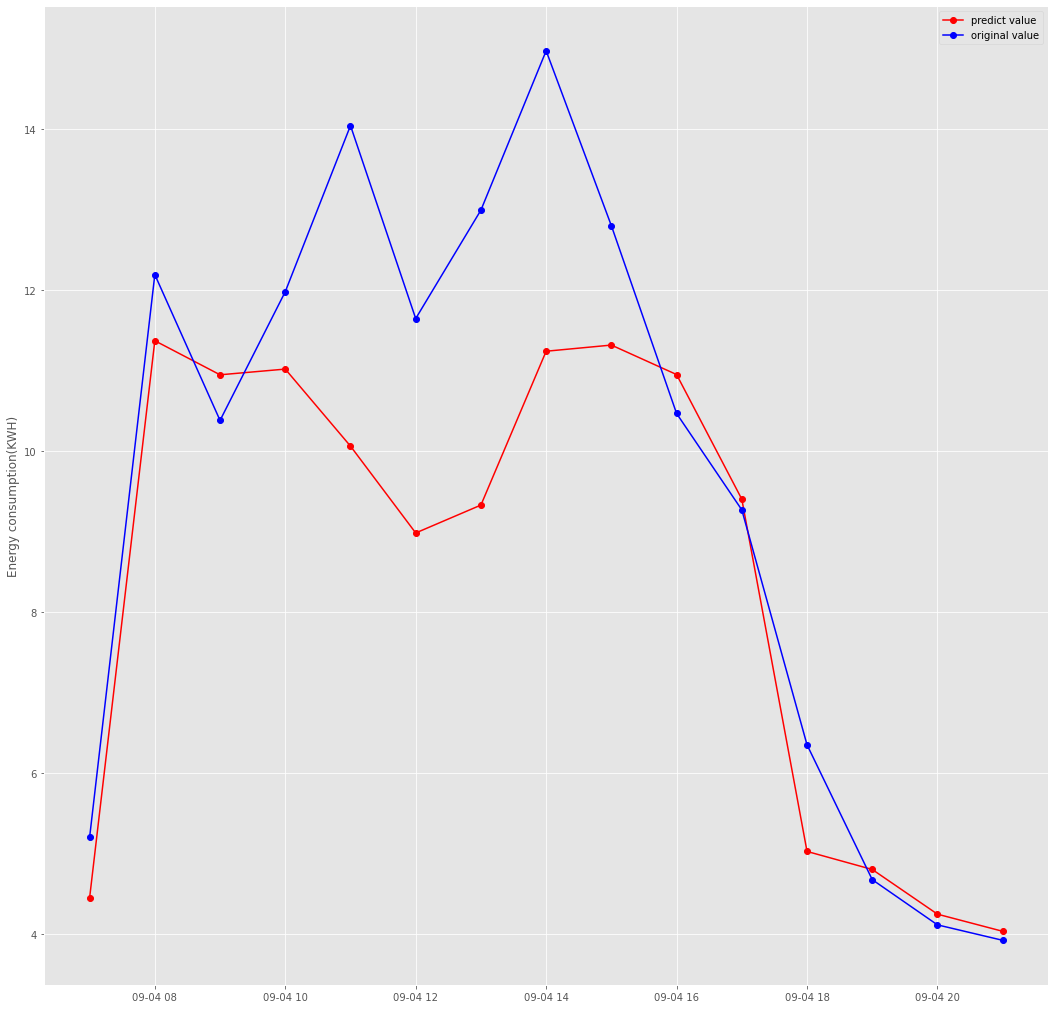

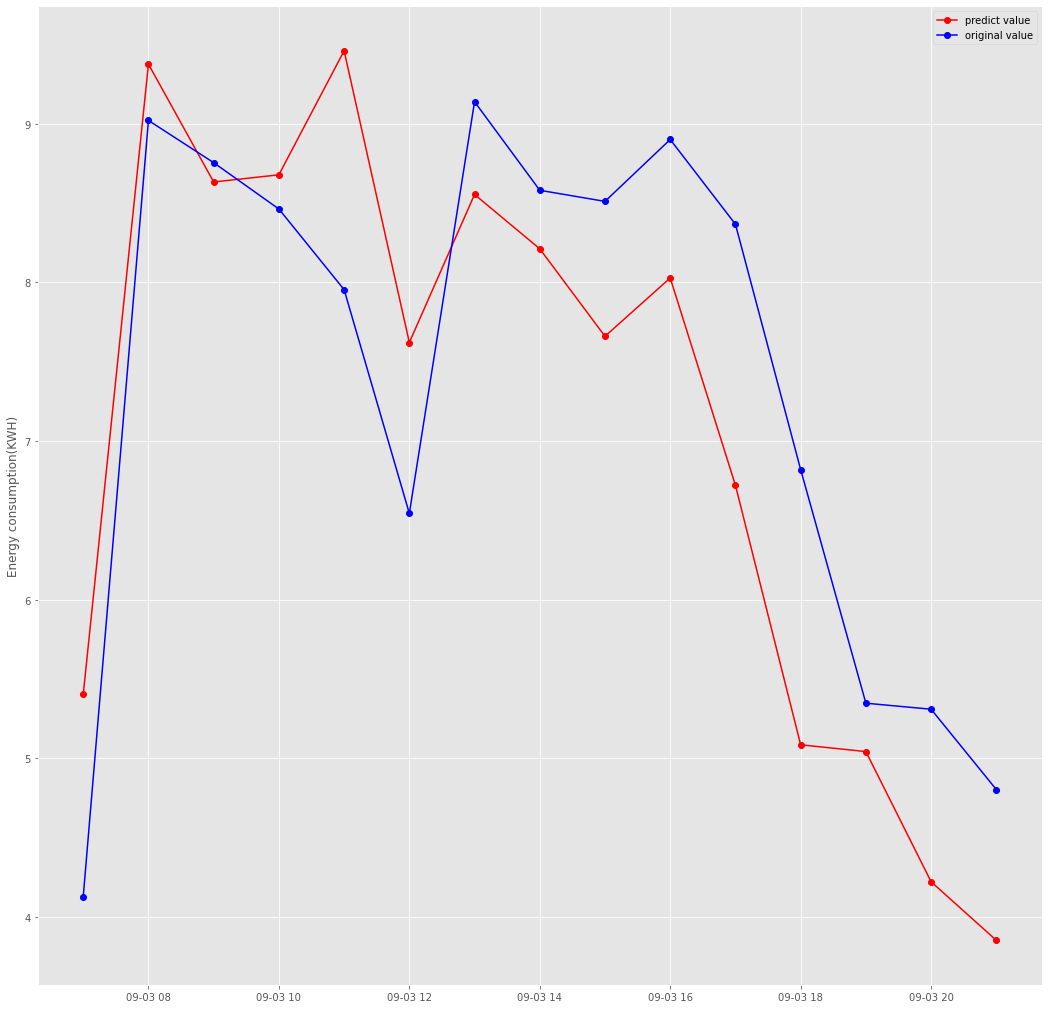

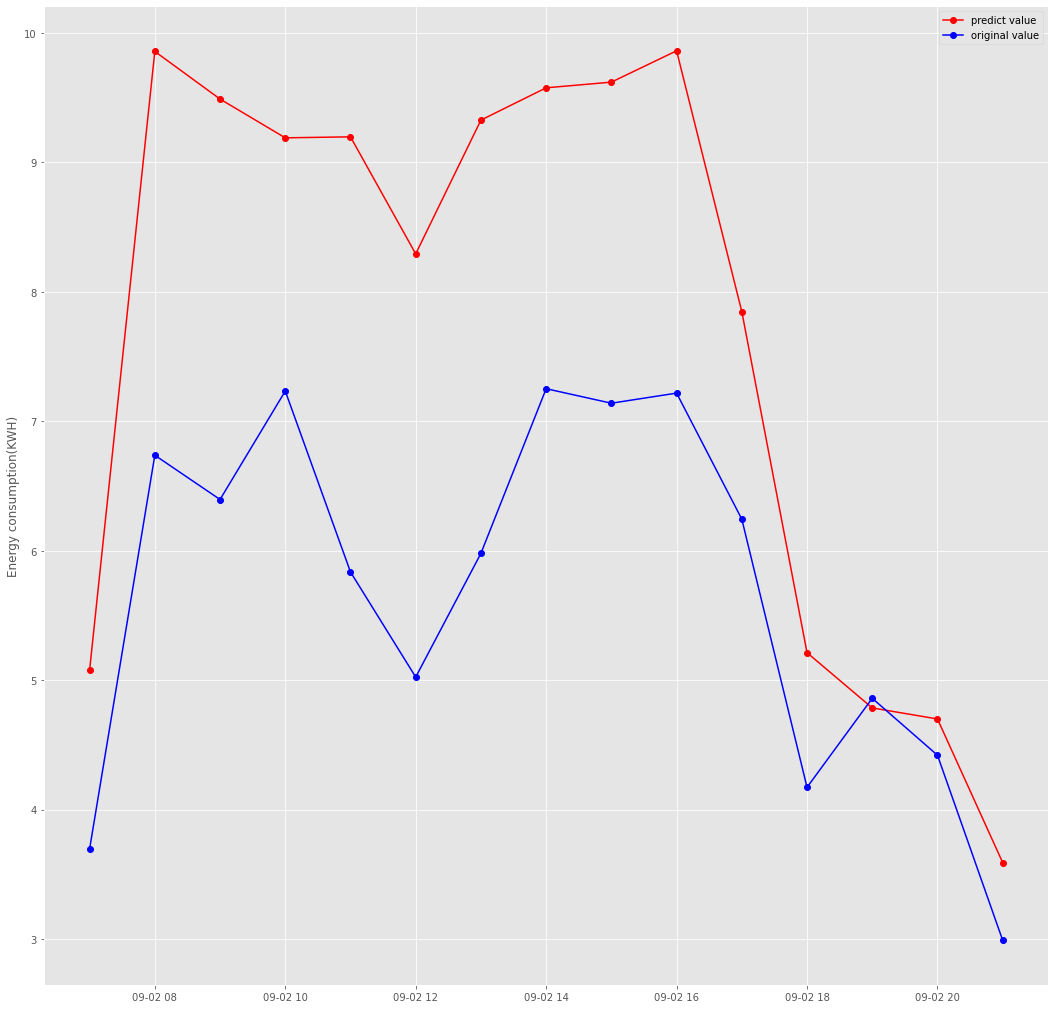

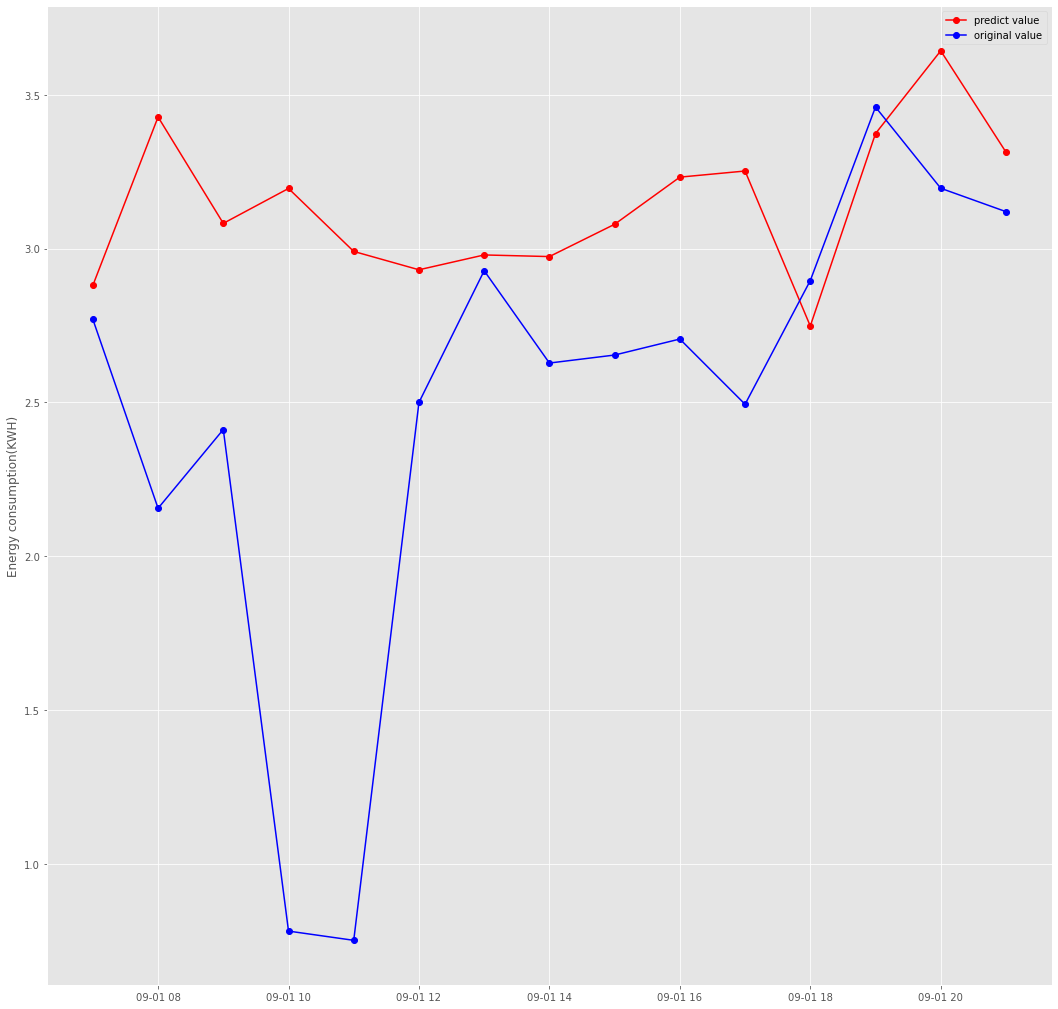

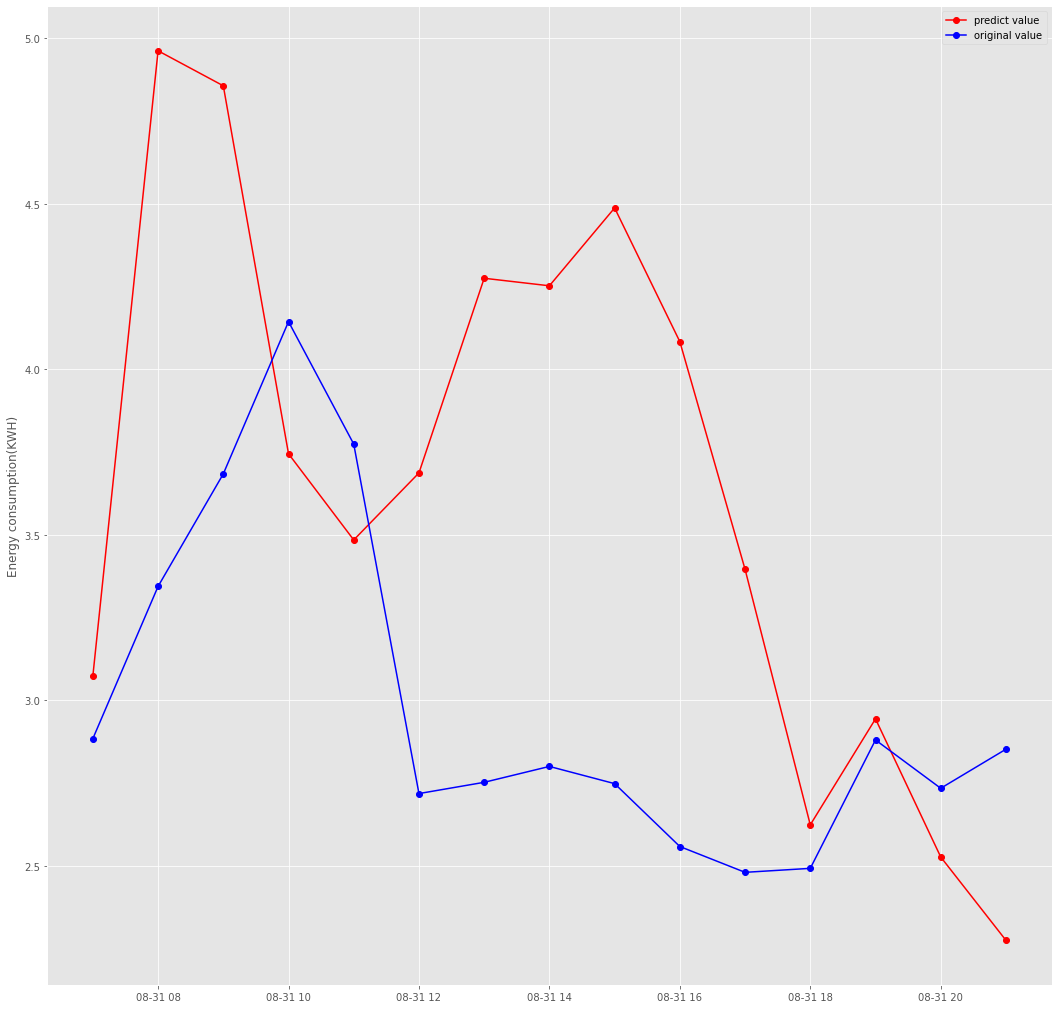

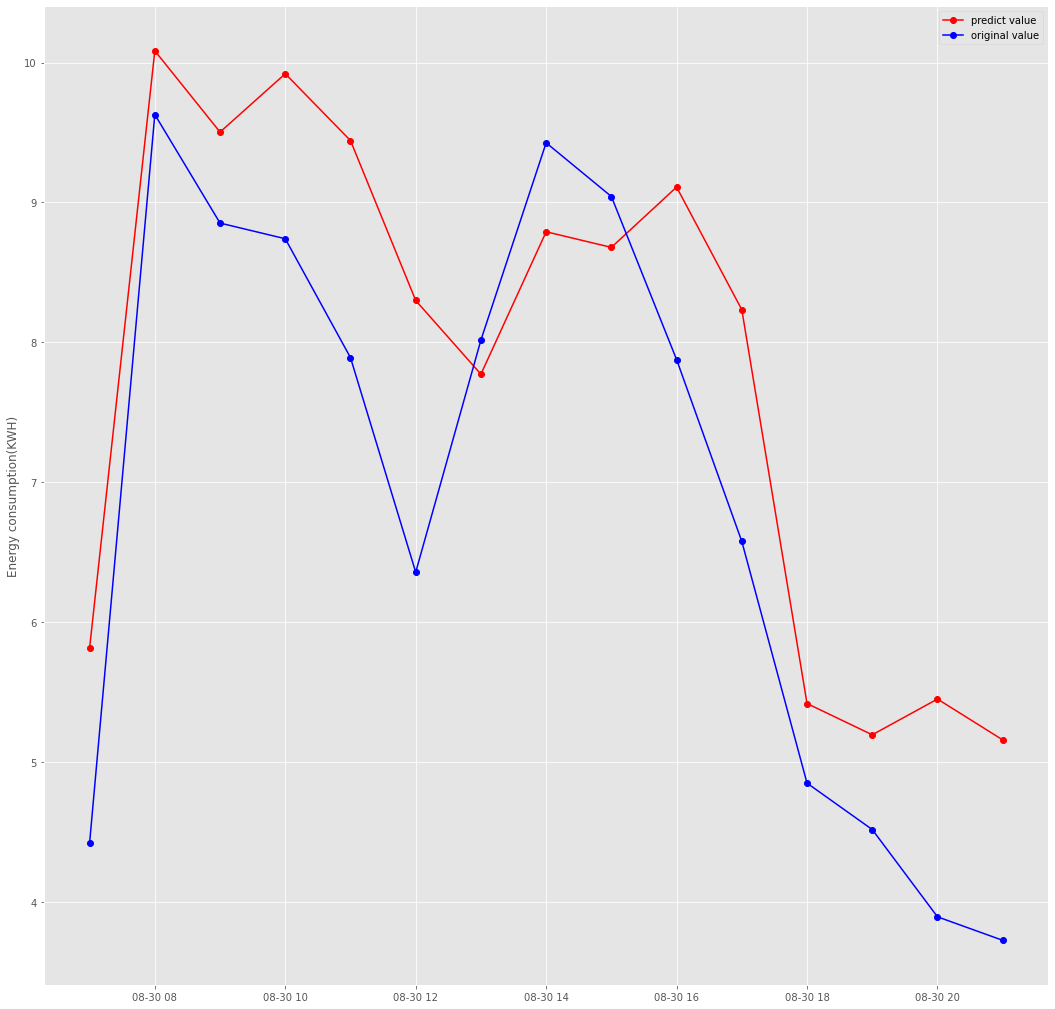

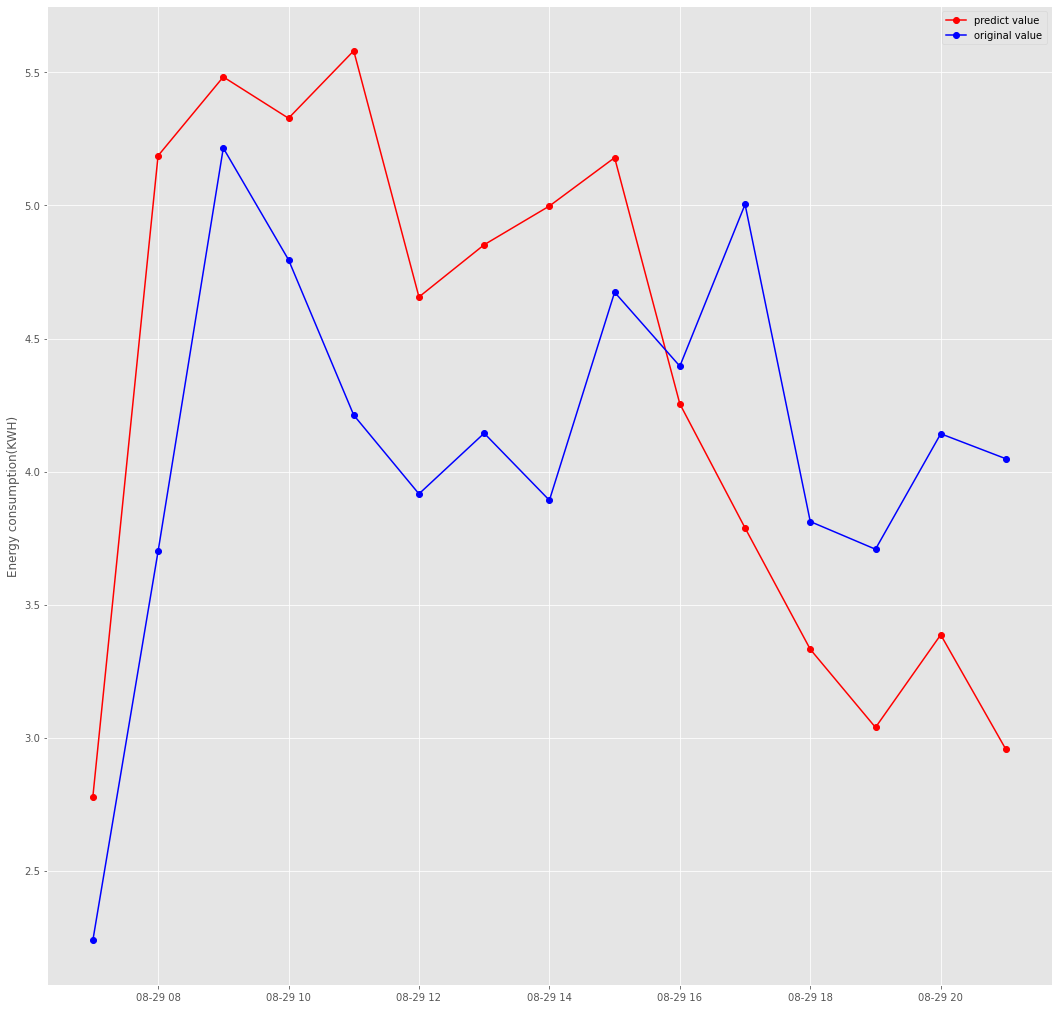

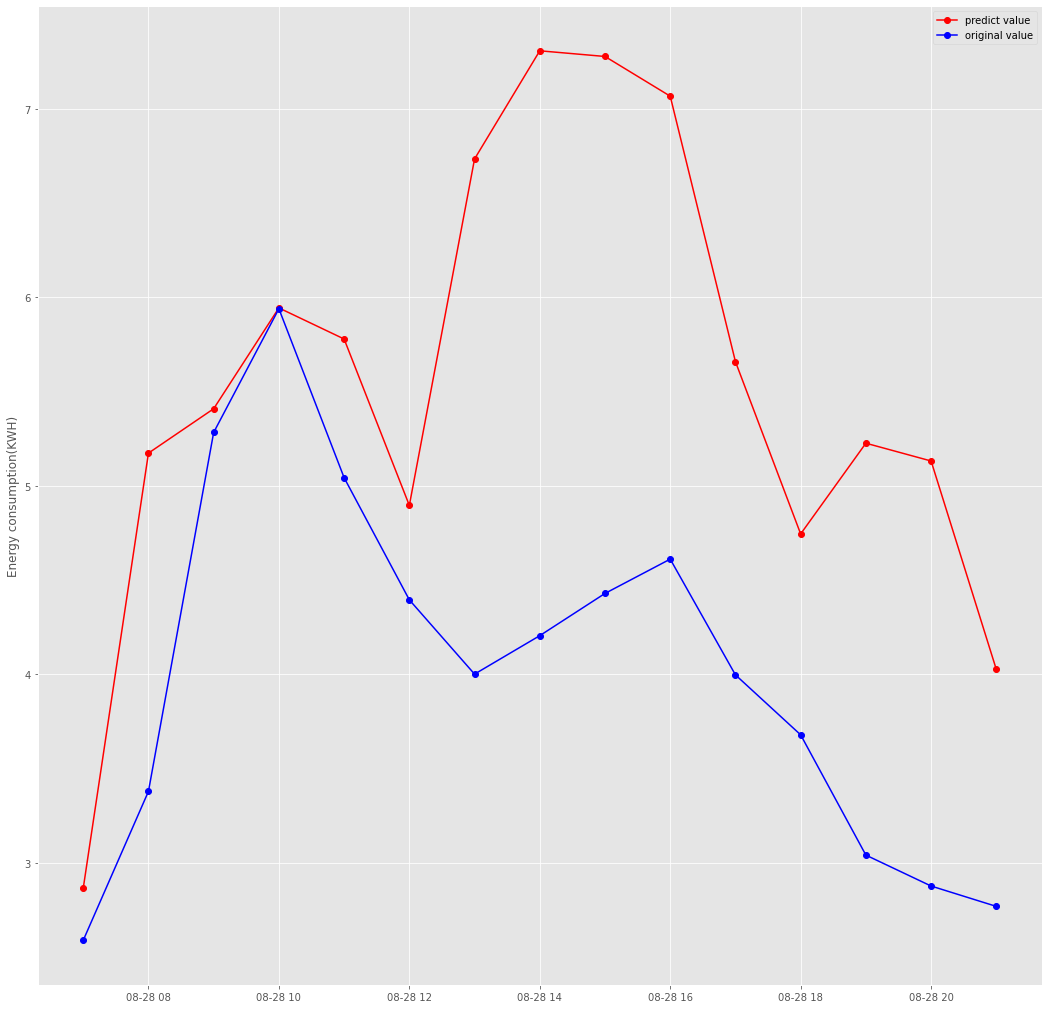

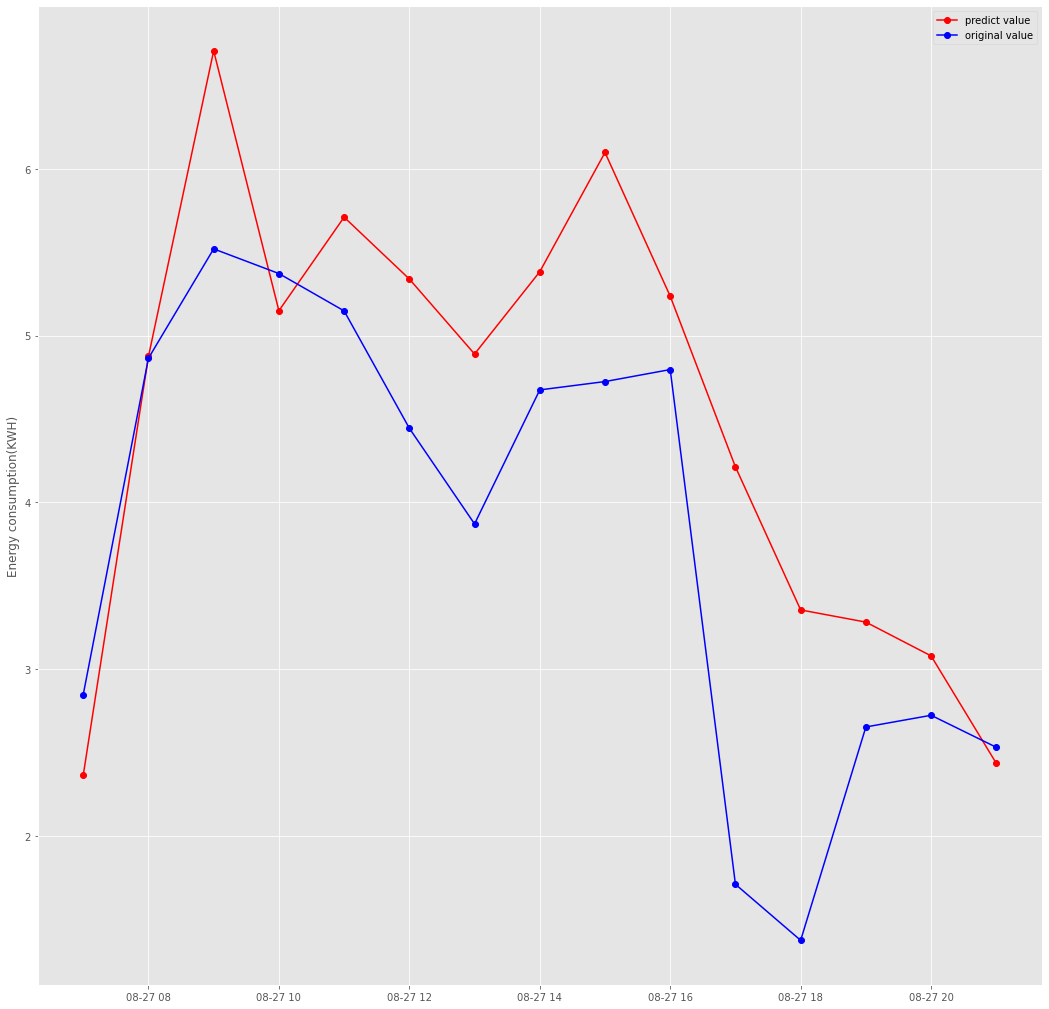

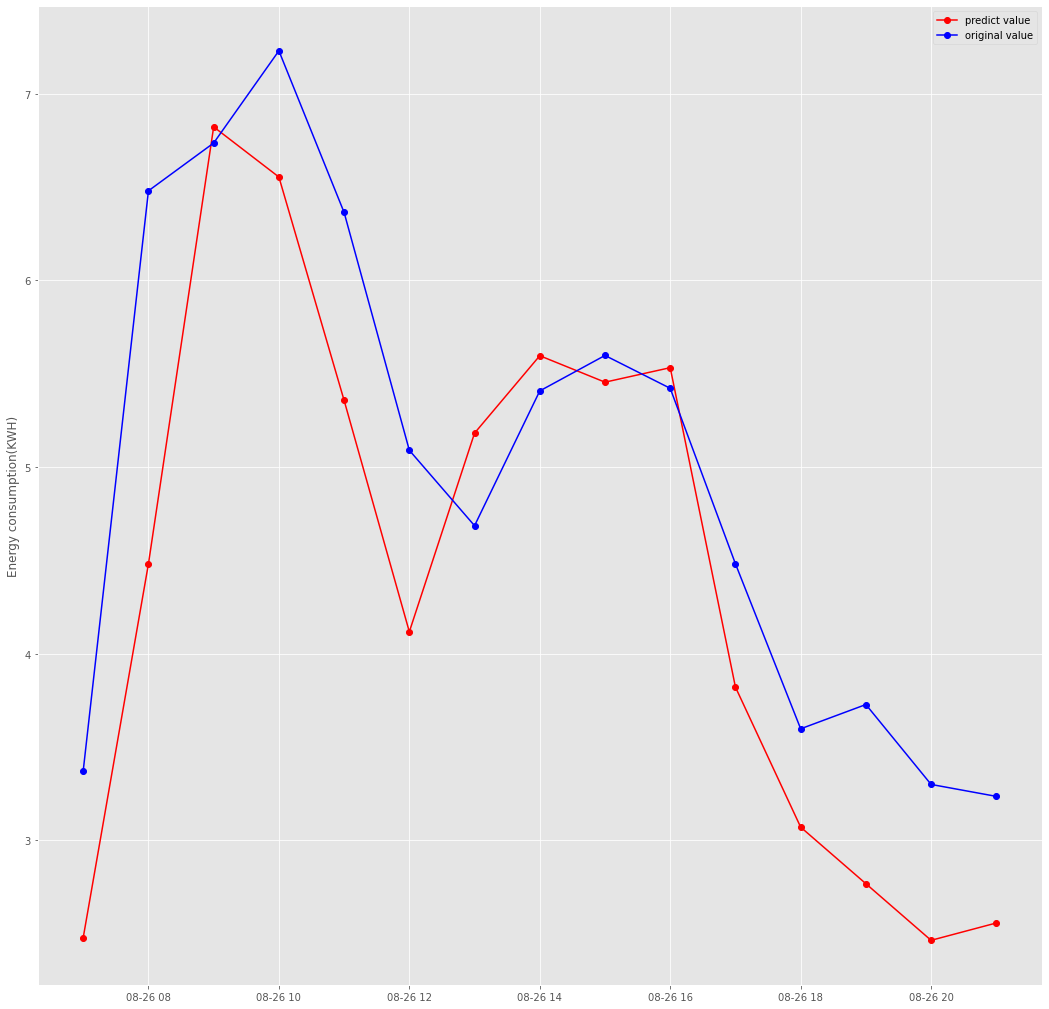

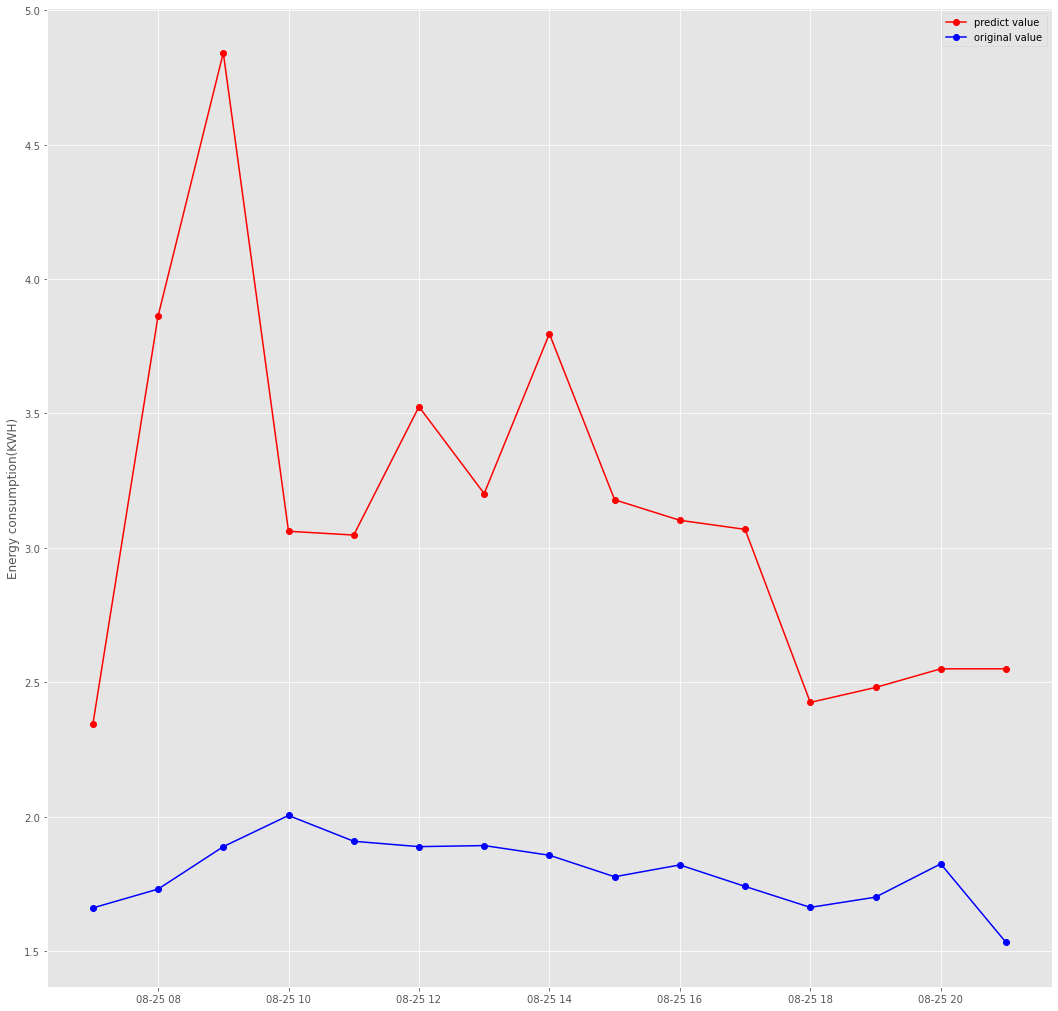

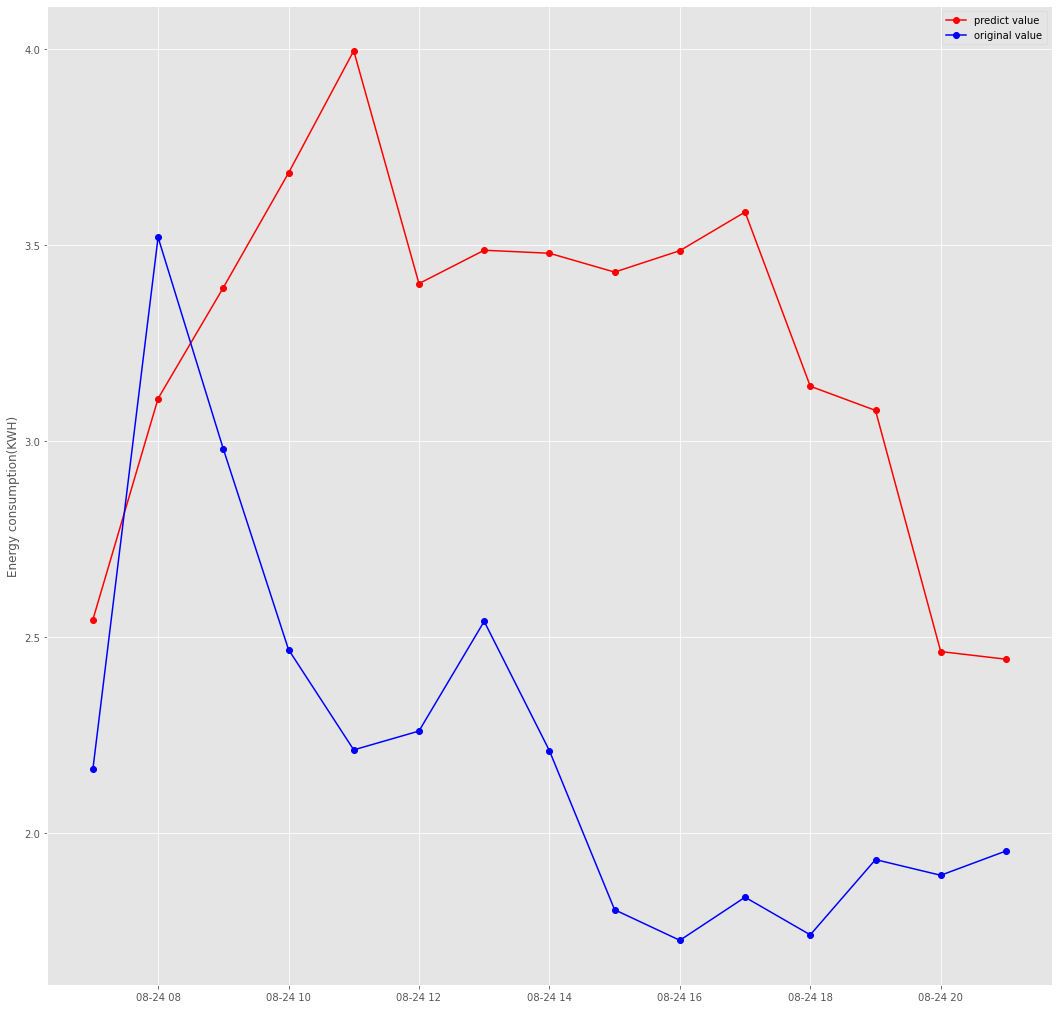

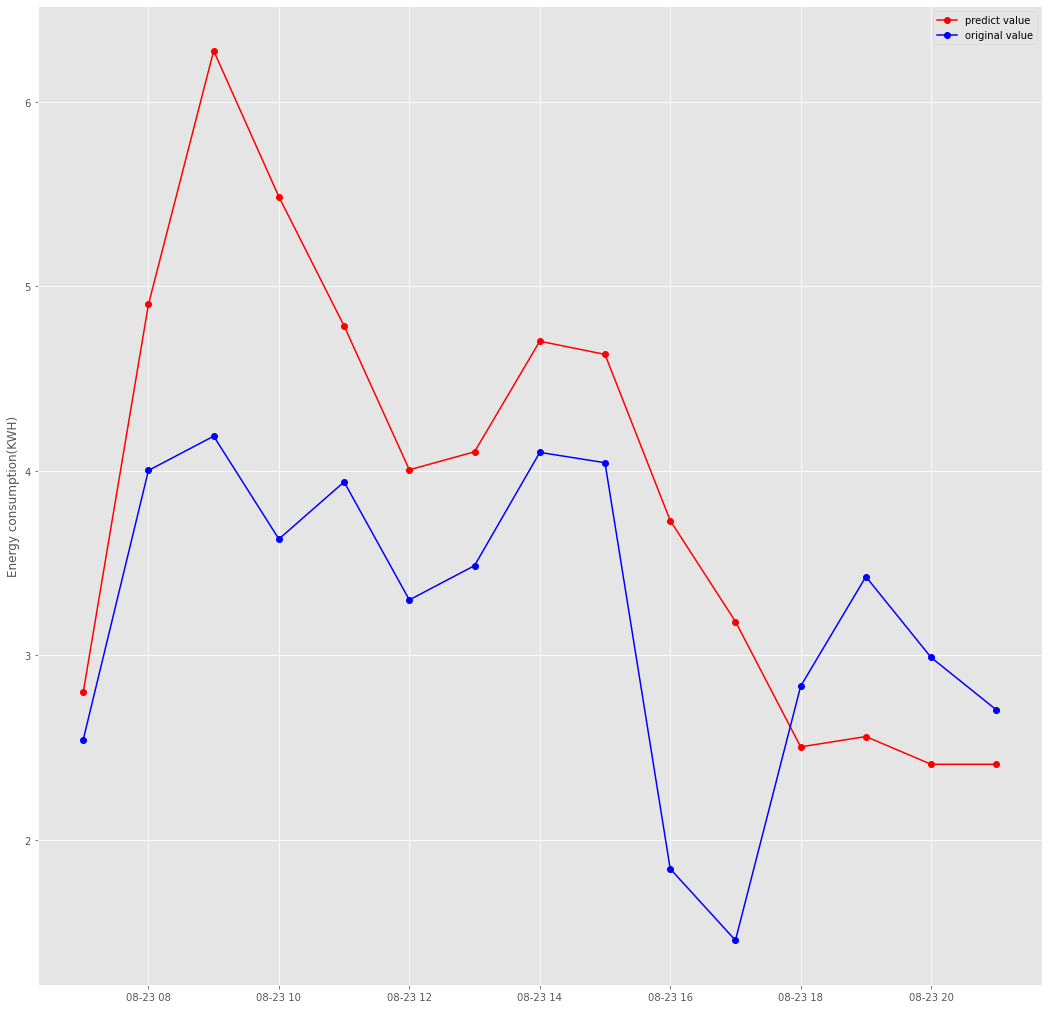

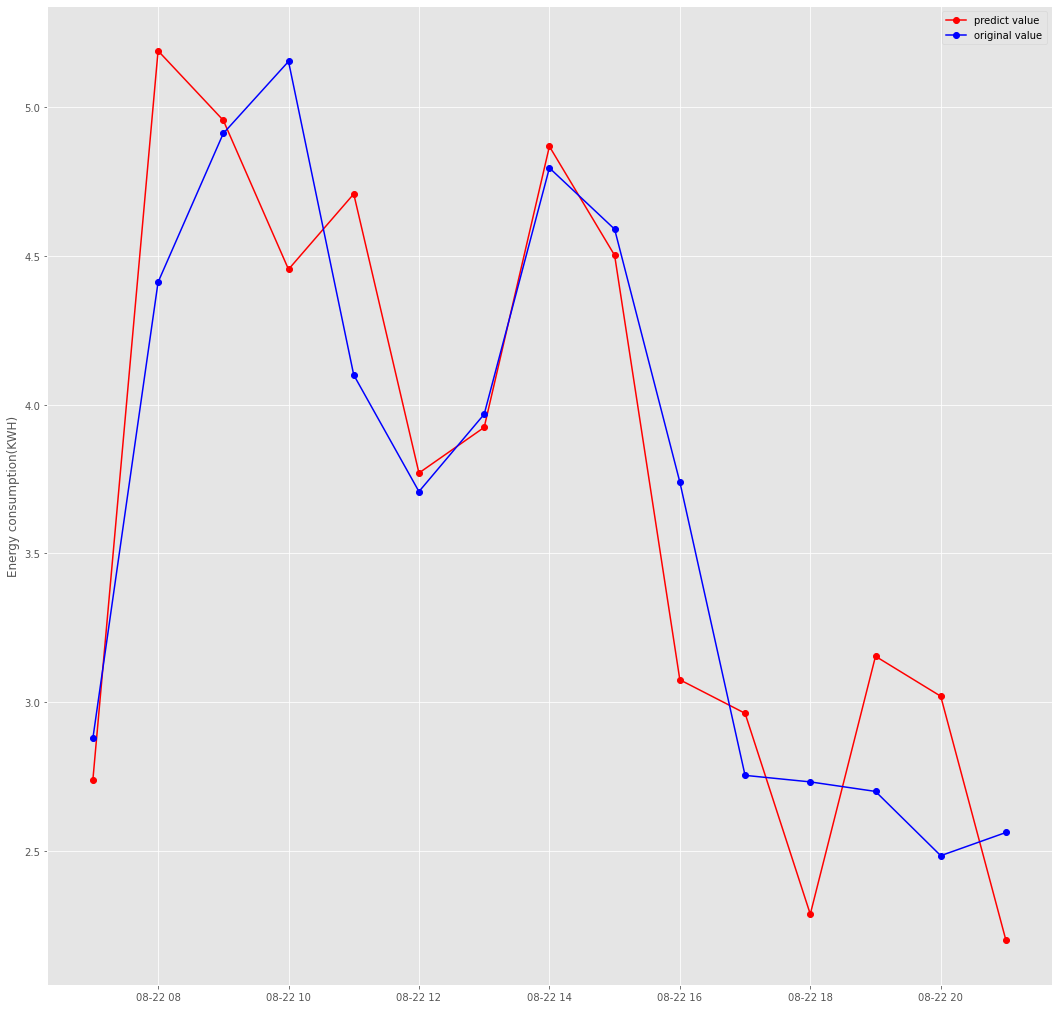

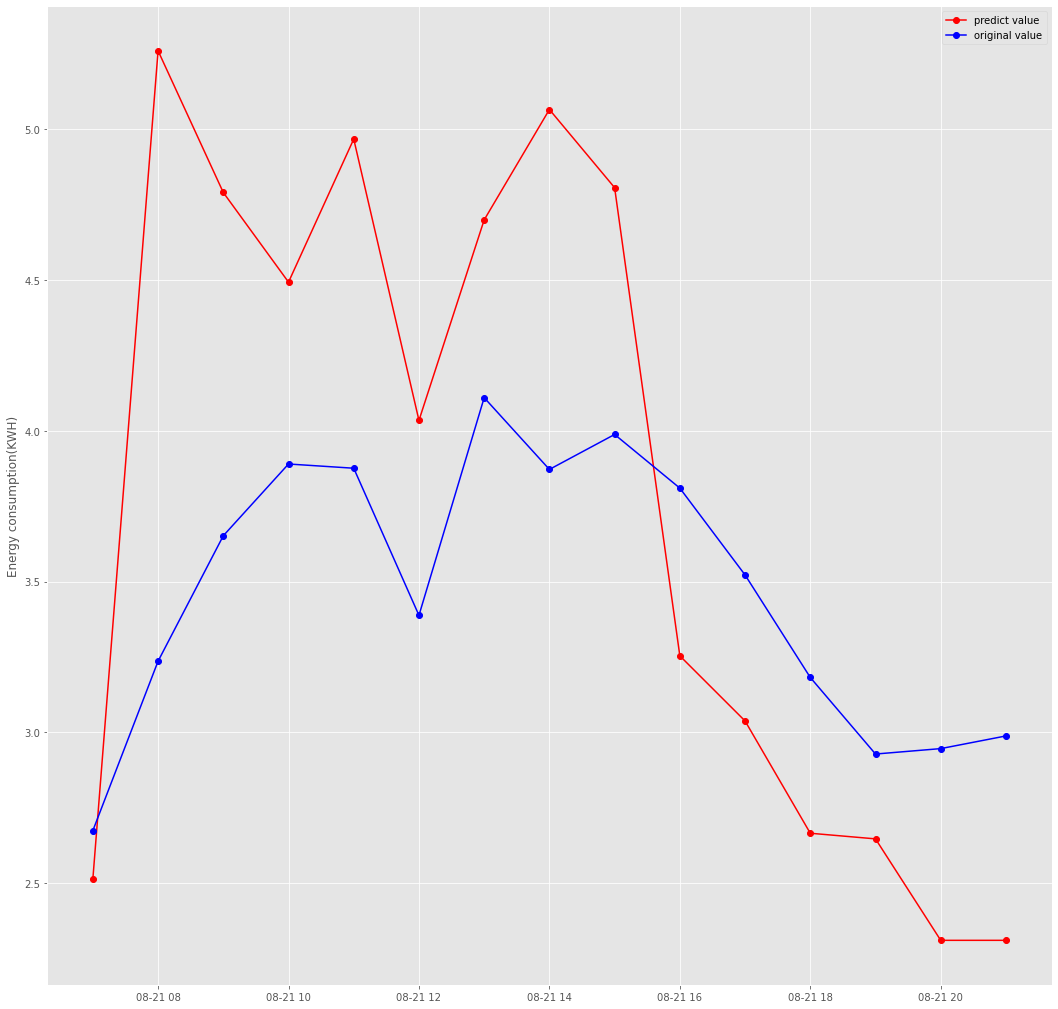

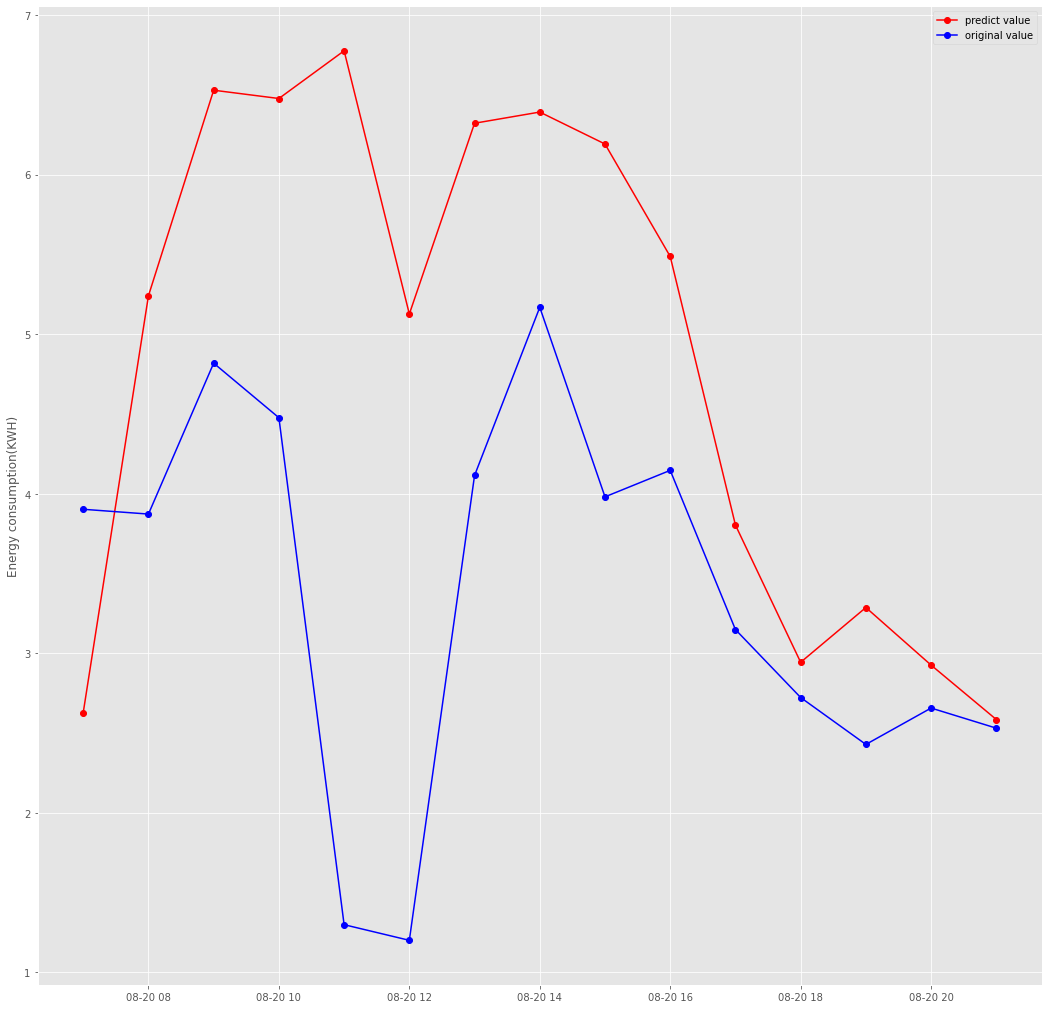

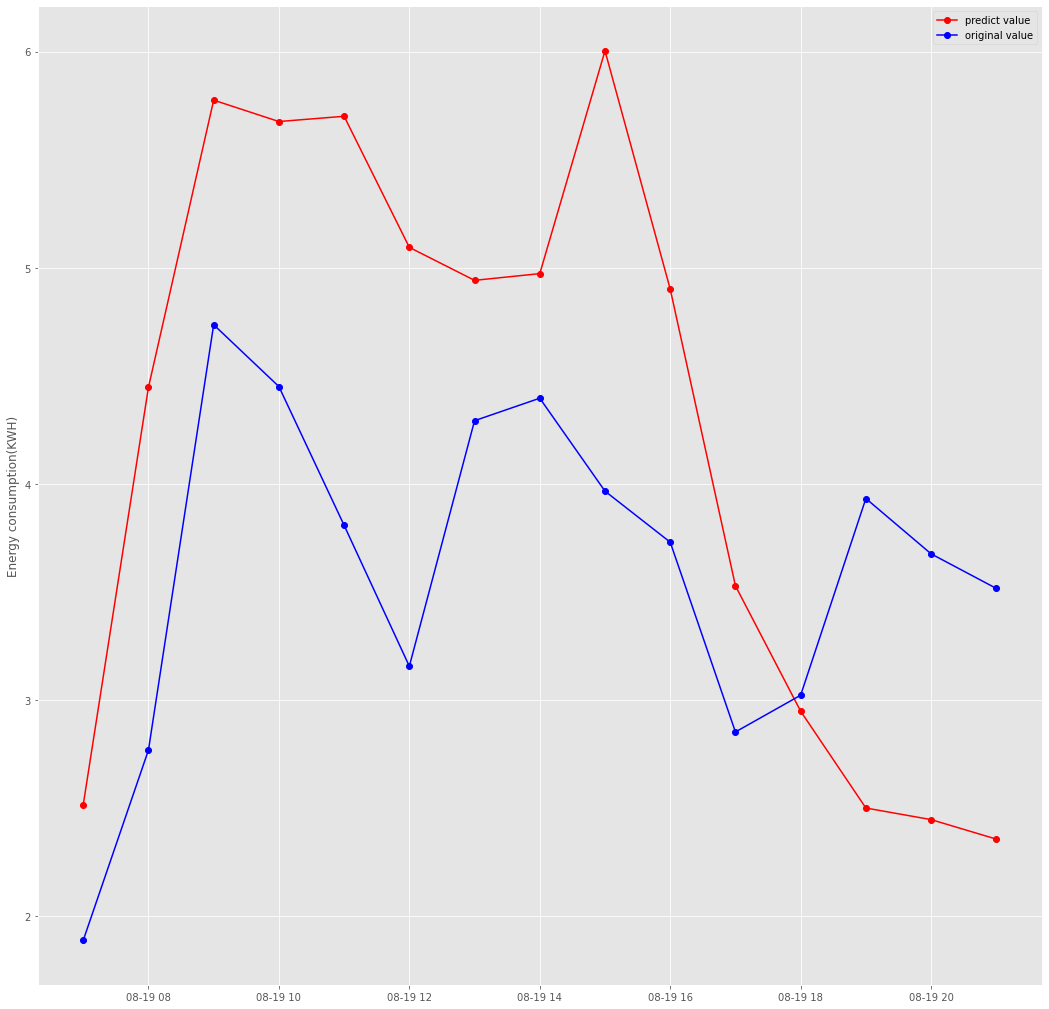

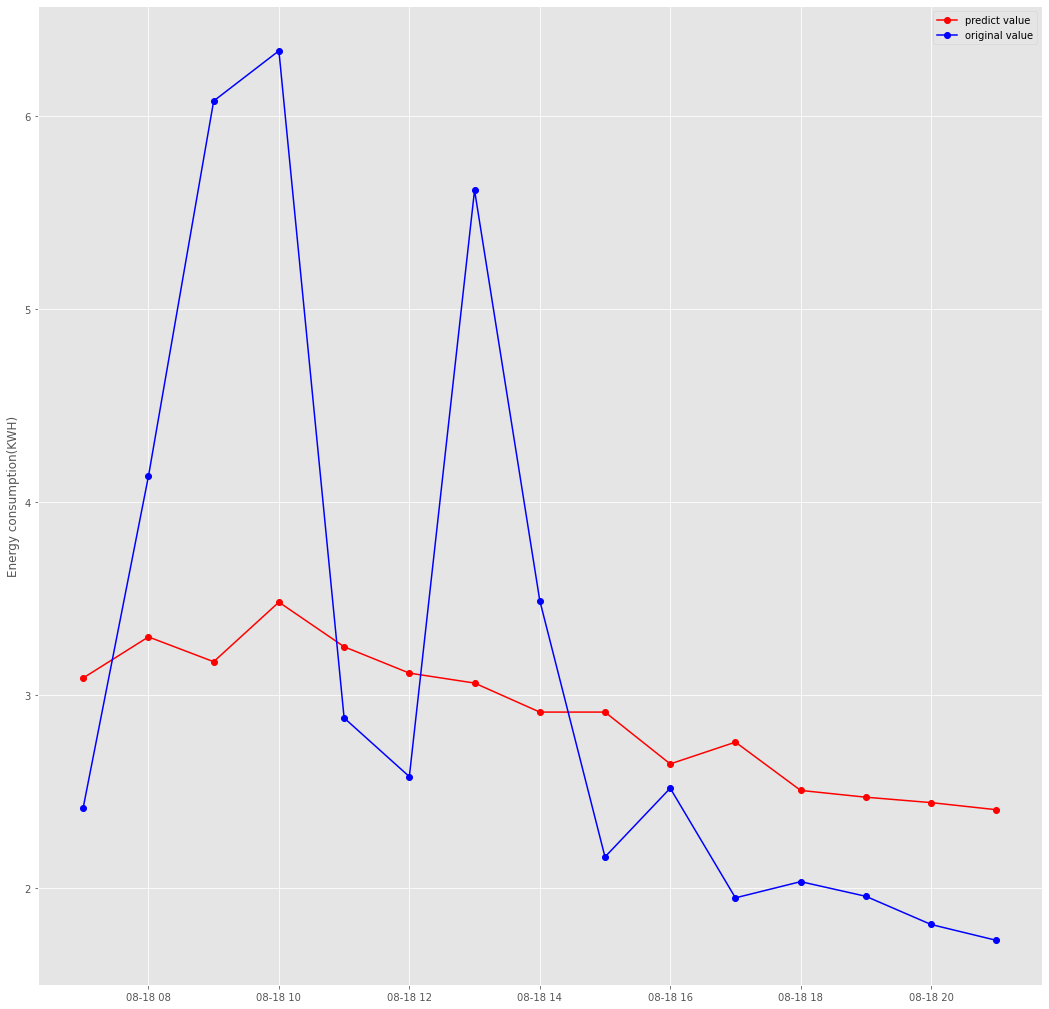

In [77]:
def plot_day_curve(i):
    plt.plot(Unit_df.iloc[(i-15):i].index, reg.predict(Xtest)[(i-15):i], 'o-'
            , color="r",label="predict value")
    plt.plot(Unit_df.iloc[(i-15):i].index, Ytest[(i-15):i], 'o-'
            , color="b",label="original value")
    plt.ylabel('Energy consumption(KWH)')
    plt.legend(loc="best")
    plt.savefig('images/{}_day_curve'.format(i))
    plt.show()

for i in range(15, 300, 15):
    plot_day_curve(-i)


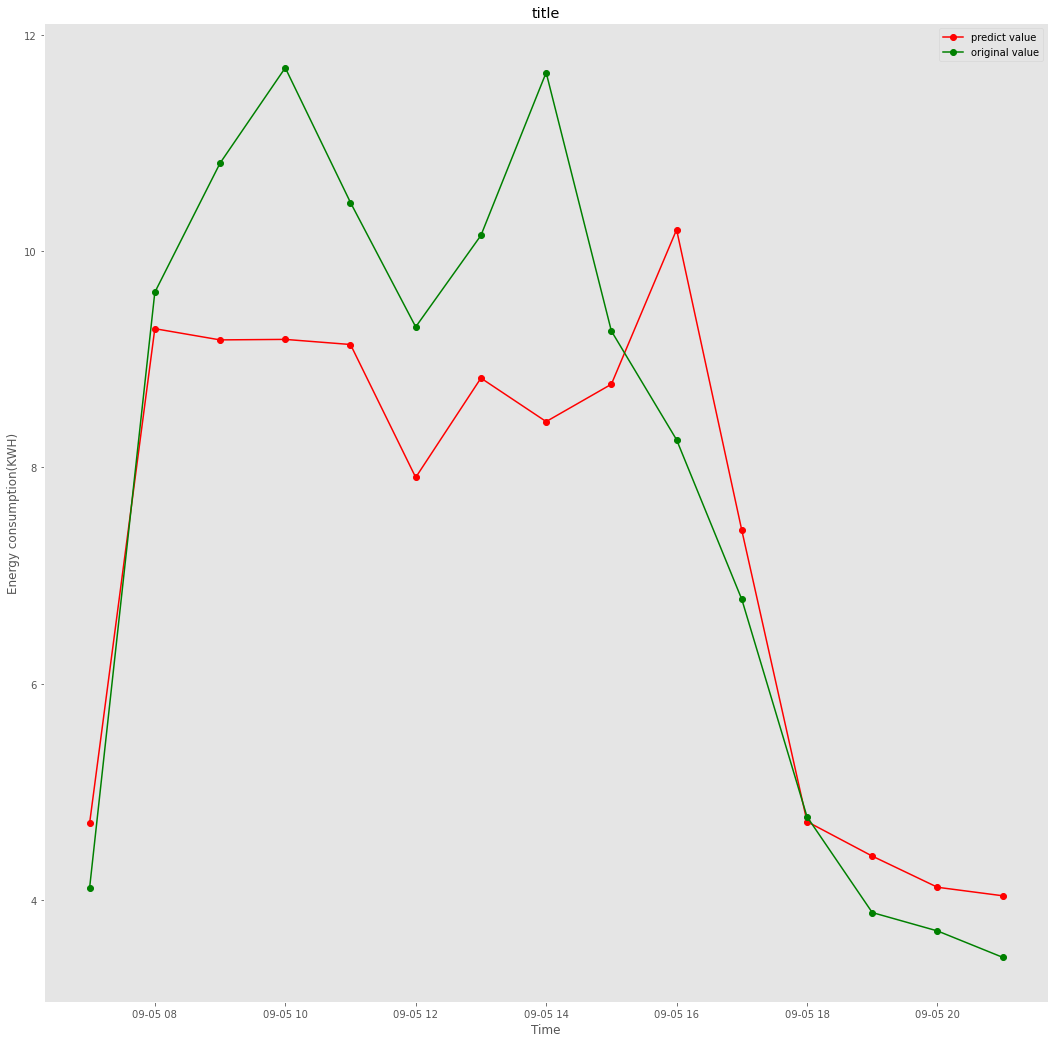

In [215]:

    
    
def plot_learning_curve(X, y1, y2,
                        ax=None, #选择子图
                        ylim=None, #设置纵坐标的取值范围
                        ):

    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title('title')
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Time")
    ax.set_ylabel("Energy consumption(KWH)")
    ax.grid() #绘制网格，不是必须
    ax.plot(X, y1, 'o-'
            , color="r",label="predict value")
    ax.plot(X, y2, 'o-'
            , color="g",label="original value")
    ax.legend(loc="best")
    plt.savefig('images/{}_day_curve'.format(i))
    plt.show()

i=-15
plot_learning_curve(Unit_df.iloc[(i-15):i].index, reg.predict(Xtest)[(i-15):i], Ytest[(i-15):i])

In [197]:
for i in range(15, 150, 15):
    print(-i)

-15
-30
-45
-60
-75
-90
-105
-120
-135


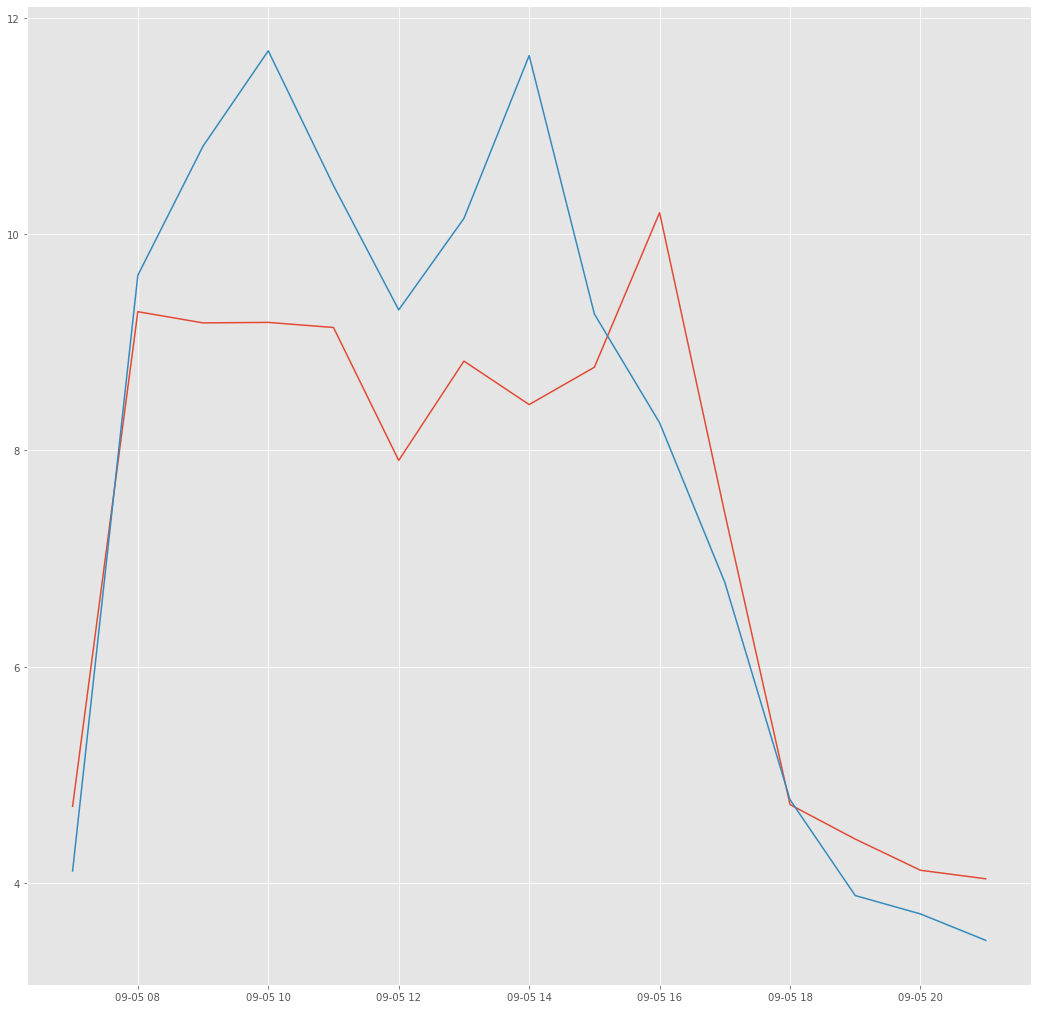

In [196]:
plt.plot(Unit_df.iloc[-15:].index, reg.predict(Xtest)[-15:], label='second line')
plt.plot(Unit_df.iloc[-15:].index, Ytest[-15:], label='second line')
reg.predict(Xtest)
plt.savefig('images/{}_day_curve'.format(i))
plt.show()

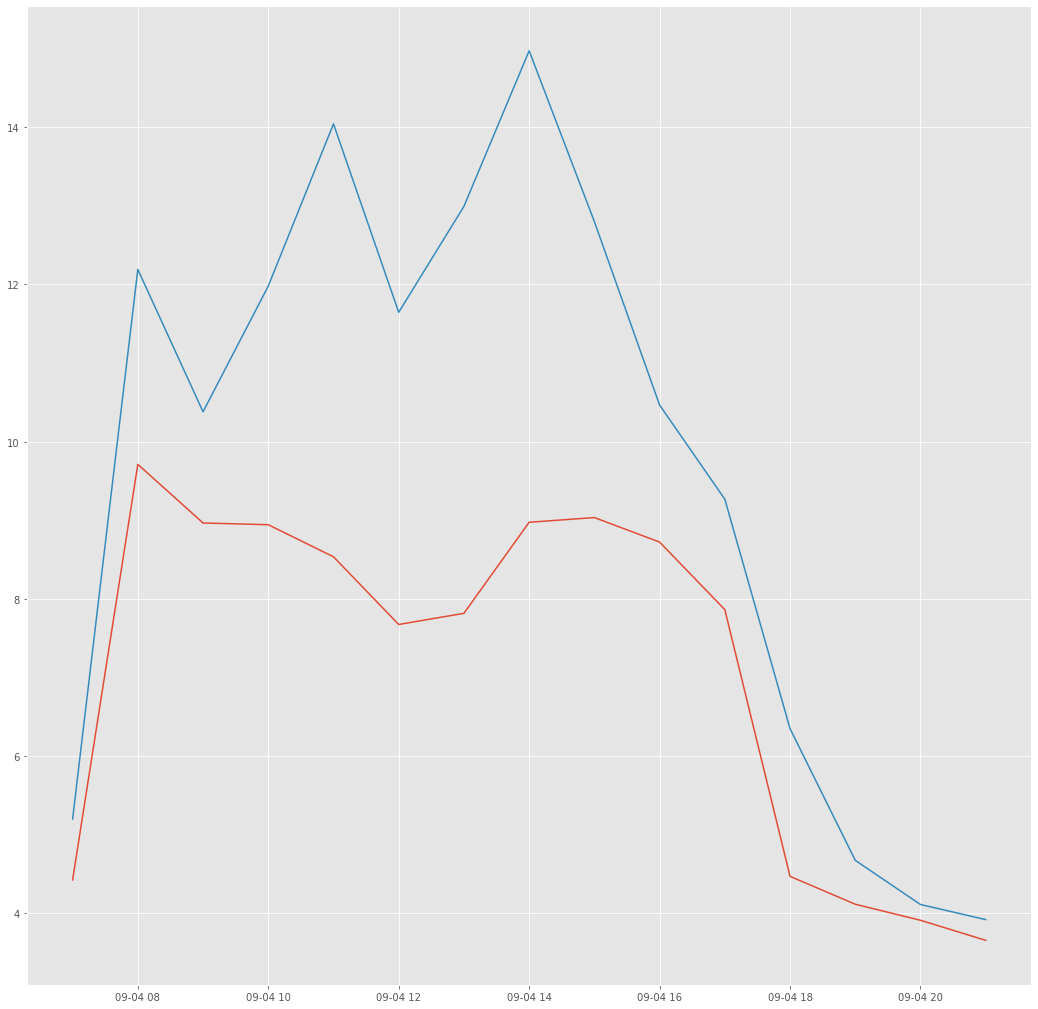

In [192]:
plt.plot(Unit_df.iloc[-45:-30].index, reg.predict(Xtest)[-45:-30],label='second line')
plt.plot(Unit_df.iloc[-45:-30].index, Ytest[-45:-30],label='second line')
reg.predict(Xtest)
plt.show()

In [50]:
import sklearn
sorted(sklearn.matrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [65]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

Xtrain,Xtest,Ytrain,Ytest = TTS(X,y,test_size=0.2,random_state=10, shuffle=False)
xgb_model = XGBRegressor(nthread=7)
cv_split = ShuffleSplit(n_splits=6, train_size=0.7, test_size=0.2)
grid_params = dict(
    max_depth = [4, 5, 6, 7],
    learning_rate = np.linspace(0.03, 0.3, 10),
    n_estimators = [100, 200]
)
grid_model = GridSearchCV(xgb_model, grid_params, cv=cv_split, scoring='neg_mean_squared_error')
grid_model.fit(Xtrain, Ytrain)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=0.7),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None,
                                    n_estimators=100, n_jobs=None, nthread=7,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             param_grid={'learning_rate': [0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ],
                         'max_depth': [4, 5, 6, 7],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=0.7),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_de...
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None, nthread=7,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                            

In [66]:
print(grid_model.best_params_)
print('rmse:', (-grid_model.best_score_) ** 0.5)

{'learning_rate': 0.12000000000000001, 'max_depth': 4, 'n_estimators': 100}
rmse: 1.33979641234614
